In [1]:
import os
import pandas as pd
import numpy as np

# LOAD DATA

In [2]:
# Load data into dataframes
dfs = {}

path = "DATA/"
 
# Get list of all files only in the given directory
fun = lambda x : os.path.isfile(os.path.join(path,x))
files_list = filter(fun, os.listdir(path))
 
# Create a list of files in directory along with the size
size_of_file = [
    (f,os.stat(os.path.join(path, f)).st_size)
    for f in files_list
]

# Iterate over list of files along with size
# and print them one by one.
for f,s in size_of_file:
    if f.find('csv') > 0:
        print("{} : {}MB".format(f, round(s/(1024*1024),3)))
        
        dataset_name = f.replace('.csv','').lower()
        try:
            dfs[dataset_name] = pd.read_csv(f'{path}{f}')
            print(dfs[dataset_name].shape)
        except:
            print(f'Load error for {dataset_name}')
        
        #dfs[dataset_name] = f'{path}{f}'

aisles.csv : 0.002MB
(134, 2)
departments.csv : 0.0MB
(21, 2)
orders.csv : 103.921MB
(3421083, 7)
order_products__prior.csv : 550.795MB
(32434489, 4)
order_products__train.csv : 23.537MB
(1384617, 4)
products.csv : 2.067MB
(49688, 4)
sample_submission.csv : 1.407MB
(75000, 2)


# COMBINE DATASETS

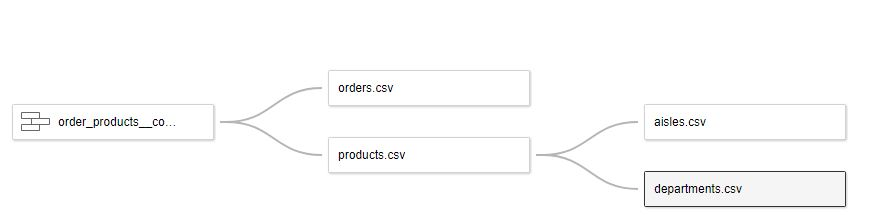

In [3]:
# create test data in a same format as train data
dfs['order_products__test'] = dfs['sample_submission'].copy()
dfs['order_products__test'].rename(columns = {'products':'product_id'}, inplace = True)
dfs['order_products__test']['product_id'] = -1
dfs['order_products__test']['add_to_cart_order'] = -1
dfs['order_products__test']['reordered'] = -1

In [4]:
# add source labels
dfs['order_products__prior']['source'] = 'prior'
dfs['order_products__train']['source'] = 'train'
dfs['order_products__test']['source'] = 'test'

In [5]:
df_order_products_all = dfs['order_products__prior'] \
                        .append(dfs['order_products__train']) \
                        .append(dfs['order_products__test'])

C:\Users\Macicek.Martin\AppData\Local\Temp\ipykernel_6856\2051870621.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_order_products_all = dfs['order_products__prior'] \


In [6]:
df_order_products_all.groupby('source')['order_id'].count()

source
prior    32434489
test        75000
train     1384617
Name: order_id, dtype: int64

In [7]:
df_order_products_all.shape

(33894106, 5)

In [8]:
df_codelists = pd.merge(pd.merge(dfs['products'], dfs['aisles'], on='aisle_id'), dfs['departments'], on='department_id')
df_codelists.shape[0] == df_codelists['product_id'].count()

True

In [9]:
df_combined = pd.merge(pd.merge(df_order_products_all, dfs['orders'], on='order_id'), df_codelists, on='product_id', how='left')           

In [10]:
df_combined.shape

(33894106, 16)

In [11]:
df_combined.query("source==eval_set")['order_id'].count()

33894106

In [12]:
# SAVE TO PARQUET FILE TO RELEASE MEMORY
df_combined.to_parquet('DATA/instacard_combined.parquet.gzip', compression='gzip', engine='fastparquet') 